# Lab 1: Generic vs. Specification-Driven Prompting
## The Research Architect Approach: Why Precision Matters

---

### 🎯 Lab Philosophy: The Research Architect Workflow

In the AI era, your value is not in writing boilerplate code but in your ability to **specify, direct, and validate** computational tasks. This lab demonstrates the critical difference between vague prompts and precise, specification-driven prompts.

**Our 5-Step Workflow:**
1. 📐 **Mathematical Formulation**: Define the problem *on paper*.
2. 📝 **Algorithmic Specification**: Design the logic and pseudocode.
3. 📋 **Define Deliverables**: State *exactly* what outputs we need.
4. 🤖 **AI-Augmented Implementation**: Write a precise prompt to generate code.
5. ✅ **Critical Validation**: Audit for bugs and economic plausibility.

---

### 📚 Coverage

**Part 1: The Optimal Growth Model**
- Comparing generic vs. specification-driven prompts.
- Using closed-form solutions for validation.

**Part 2: Estimating AR(1) TFP Shocks**
- Generic prompt pitfalls.
- Specification-driven approach for macroeconomic estimation.

**Part 3: Discussion**
- When does prompt precision matter most?

---

# Part 1: The Optimal Growth Model

We begin with a classic problem that has a **closed-form solution**—the optimal growth model with full depreciation and log utility. This allows us to validate AI-generated code against the true answer.

## 1. Mathematical Formulation

**The Planner's Problem:**
$$
\max_{\{c_t, k_{t+1}\}} \sum_{t=0}^{\infty} \beta^t \ln(c_t)
$$
subject to:
$$
c_t + k_{t+1} = k_t^\alpha
$$

where $\delta = 1$ (full depreciation).

**Closed-Form Solution:**

With log utility and full depreciation, the optimal policy functions are:
$$
k_{t+1} = \alpha \beta k_t^\alpha, \quad c_t = (1 - \alpha\beta) k_t^\alpha
$$

**Steady State:**
$$
k^* = (\alpha \beta)^{\frac{1}{1-\alpha}}
$$

This closed-form solution is our **validation benchmark**.

## 2. The Generic Prompt Approach

A student might ask an AI:

----
❌ **Generic Prompt:**

"Write Python code to solve the optimal growth model."

----

**Problems with this prompt:**
- Which utility function? (CRRA? Log? Linear?)
- What depreciation rate?
- What solution method? (VFI? Euler equation iteration? Shooting?)
- What outputs are needed?

The AI will make assumptions—often inconsistent with what you need. Let's see what happens.

Pre-computing return matrix...
Starting Value Function Iteration (tol=1e-06)...
Converged in 181 iterations. Time: 0.0803s


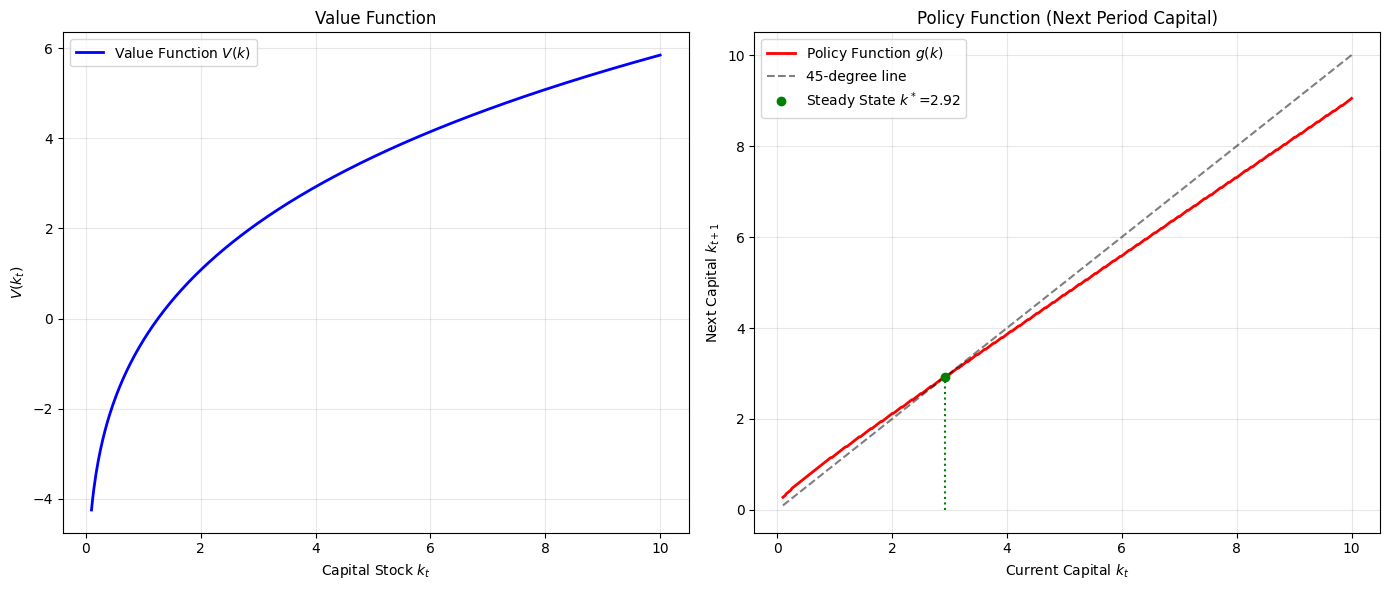

In [5]:
# Typical AI output from a generic prompt
# (Often uses arbitrary parameters and methods)

import numpy as np
import matplotlib.pyplot as plt
import time

class OptimalGrowthModel:
    def __init__(self, alpha=0.3, beta=0.96, delta=0.1, sigma=2.0, k_min=0.1, k_max=10.0, grid_size=200):
        """
        Initialize the Optimal Growth Model parameters.

        Parameters:
        alpha (float): Capital share in production (Cobb-Douglas)
        beta (float): Discount factor
        delta (float): Depreciation rate
        sigma (float): Coefficient of relative risk aversion (CRRA)
        k_min (float): Minimum capital grid value
        k_max (float): Maximum capital grid value
        grid_size (int): Number of grid points
        """
        self.alpha = alpha
        self.beta = beta
        self.delta = delta
        self.sigma = sigma
        self.grid_size = grid_size

        # Create capital grid
        self.k_grid = np.linspace(k_min, k_max, grid_size)

        # Initialize Value Function (guess V=0)
        self.V = np.zeros(grid_size)
        self.policy = np.zeros(grid_size, dtype=int) # Stores indices of optimal k'

        # Pre-compute the Return Matrix M[i, j] = Utility(c) if transitioning from k[i] to k[j]
        # This speeds up the iteration significantly compared to loops.
        self.M = self._compute_return_matrix()

    def production(self, k):
        """Cobb-Douglas production function"""
        return k ** self.alpha

    def utility(self, c):
        """CRRA Utility function"""
        # Small epsilon to avoid log(0) or division by zero
        epsilon = 1e-10
        c = np.maximum(c, epsilon)

        if self.sigma == 1:
            return np.log(c)
        else:
            return (c**(1 - self.sigma) - 1) / (1 - self.sigma)

    def _compute_return_matrix(self):
        """
        Computes the utility matrix for all possible transitions.
        Row i corresponds to current k_t.
        Column j corresponds to chosen k_{t+1}.
        """
        print("Pre-computing return matrix...")

        # Broadcasting to create a matrix of consumption
        # k_grid.reshape(-1, 1) is k_t (rows)
        # k_grid.reshape(1, -1) is k_{t+1} (columns)

        k_t = self.k_grid.reshape(-1, 1)
        k_next = self.k_grid.reshape(1, -1)

        # Budget constraint: c = f(k) + (1-delta)k - k'
        resource = self.production(k_t) + (1 - self.delta) * k_t
        consumption = resource - k_next

        # Filter out infeasible consumption (c <= 0)
        # We assign a very large negative penalty to infeasible choices
        mask = consumption <= 0

        U = self.utility(consumption)
        U[mask] = -1e10 # Heavy penalty for infeasible transitions

        return U

    def solve(self, tol=1e-6, max_iter=1000):
        """
        Solves the model using Value Function Iteration.
        """
        print(f"Starting Value Function Iteration (tol={tol})...")
        start_time = time.time()

        for i in range(max_iter):
            # Bellman operator: V_new(k) = max_{k'} { u(c) + beta * V_old(k') }
            # self.M is [N, N], self.V is [N]
            # We add V to every row of M (broadcasting)

            # Values[i, j] represents utility of moving from i to j + discounted value of being at j
            values = self.M + self.beta * self.V

            # Maximize over columns (choice of k') to get new V for each row (current k)
            V_new = np.max(values, axis=1)
            policy_indices = np.argmax(values, axis=1)

            # Check convergence
            dist = np.max(np.abs(V_new - self.V))
            self.V = V_new
            self.policy = policy_indices

            if dist < tol:
                elapsed = time.time() - start_time
                print(f"Converged in {i+1} iterations. Time: {elapsed:.4f}s")
                self.plot_solution()
                return

        print("Did not converge within max iterations.")

    def get_steady_state_analytical(self):
        """
        Calculates the analytical steady state capital k* for comparison.
        f'(k*) = (1/beta) - (1-delta)
        alpha * k^(alpha-1) = (1/beta) - 1 + delta
        """
        denom = (1 / self.beta) - (1 - self.delta)
        k_star = (self.alpha / denom) ** (1 / (1 - self.alpha))
        return k_star

    def plot_solution(self):
        """Plots the Value Function and Policy Function."""
        k_star = self.get_steady_state_analytical()
        opt_k_next = self.k_grid[self.policy]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

        # Plot Value Function
        ax1.plot(self.k_grid, self.V, label='Value Function $V(k)$', color='blue', linewidth=2)
        ax1.set_title('Value Function')
        ax1.set_xlabel('Capital Stock $k_t$')
        ax1.set_ylabel('$V(k_t)$')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot Policy Function
        ax2.plot(self.k_grid, opt_k_next, label='Policy Function $g(k)$', color='red', linewidth=2)
        ax2.plot(self.k_grid, self.k_grid, 'k--', alpha=0.5, label='45-degree line')

        # Mark Steady State
        ax2.plot(k_star, k_star, 'go', label=f'Steady State $k^*$={k_star:.2f}')
        ax2.vlines(k_star, 0, k_star, colors='green', linestyles='dotted')

        ax2.set_title('Policy Function (Next Period Capital)')
        ax2.set_xlabel('Current Capital $k_t$')
        ax2.set_ylabel('Next Capital $k_{t+1}$')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    # Instantiate and run
    model = OptimalGrowthModel(
        alpha=0.3,
        beta=0.96,
        delta=0.1,
        sigma=1.5,
        grid_size=500
    )
    model.solve()

**Issues with generic output:**
1. Uses $\delta = 0.025$ instead of $\delta = 1$ (no closed-form validation possible).
2. No convergence criterion—just runs 100 iterations.
3. No policy function extraction.
4. No comparison to analytical solution.
5. Coarse grid may miss accuracy.

## 3. The Specification-Driven Approach

Now let's apply the Research Architect workflow.

----
✅ **Specification-Driven Prompt:**

"Solve the deterministic optimal growth model with:

**Model:**
- Log utility: $u(c) = \ln(c)$
- Production: $y = k^\alpha$
- Full depreciation: $\delta = 1$
- Resource constraint: $c + k' = k^\alpha$

**Parameters:** $\alpha = 0.33$, $\beta = 0.96$

**Method:** Value Function Iteration on a grid of 200 points from $k \in [0.01, 2.0]$.

**Convergence:** Stop when $\|V_{n+1} - V_n\|_\infty < 10^{-6}$.

**Deliverables:**
1. Plot the converged value function.
2. Extract and plot the policy function $k'(k)$.
3. Compare the numerical policy to the analytical solution $k' = \alpha\beta k^\alpha$.
4. Report the maximum absolute error."

----

Converged in 339 iterations. Final error: 9.80e-07


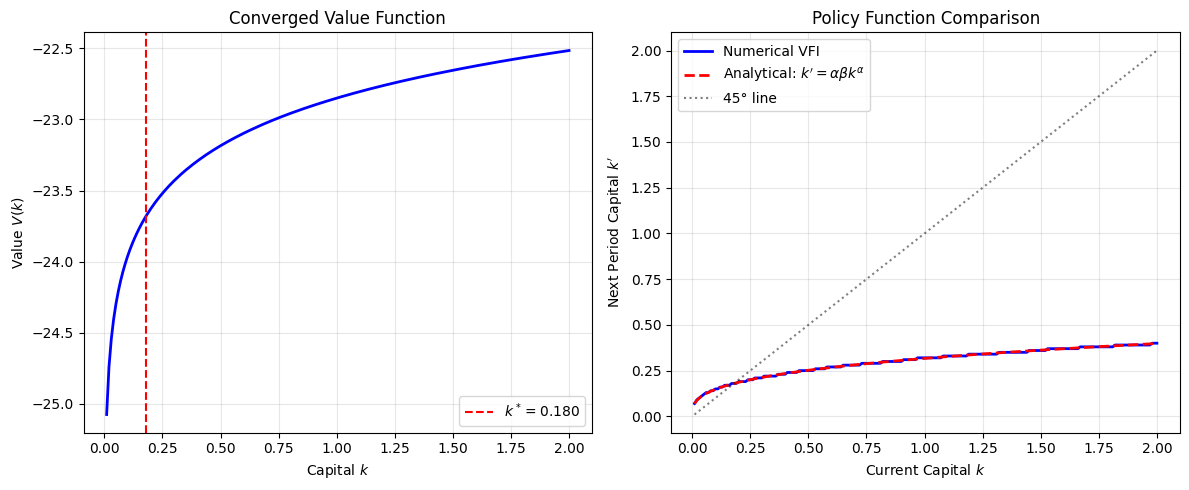


Maximum Policy Function Error: 0.007310
Analytical Steady State: k* = 0.1798


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. PARAMETERS (Specified)
# =============================================================================
alpha = 0.33
beta = 0.96
delta = 1.0  # Full depreciation (enables closed-form solution)

# =============================================================================
# 2. GRID (Specified)
# =============================================================================
n_k = 200
k_min, k_max = 0.01, 2.0
k_grid = np.linspace(k_min, k_max, n_k)

# =============================================================================
# 3. VALUE FUNCTION ITERATION
# =============================================================================
V = np.zeros(n_k)
policy_idx = np.zeros(n_k, dtype=int)
tol = 1e-6
max_iter = 1000

for iteration in range(max_iter):
    V_new = np.zeros(n_k)
    
    for i, k in enumerate(k_grid):
        # Output available for consumption and investment
        y = k ** alpha
        
        # Consumption for each possible k'
        c = y - k_grid  # c = k^alpha - k'
        c[c <= 0] = 1e-10  # Avoid log(0)
        
        # Value for each choice
        values = np.log(c) + beta * V
        values[c <= 1e-10] = -np.inf  # Infeasible choices
        
        # Optimal choice
        V_new[i] = np.max(values)
        policy_idx[i] = np.argmax(values)
    
    # Check convergence (sup norm)
    error = np.max(np.abs(V_new - V))
    V = V_new.copy()
    
    if error < tol:
        print(f"Converged in {iteration+1} iterations. Final error: {error:.2e}")
        break

# Extract policy function
k_policy = k_grid[policy_idx]

# =============================================================================
# 4. ANALYTICAL SOLUTION (For Validation)
# =============================================================================
k_policy_analytical = alpha * beta * k_grid ** alpha
k_star = (alpha * beta) ** (1 / (1 - alpha))

# =============================================================================
# 5. DELIVERABLES
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Value Function
axes[0].plot(k_grid, V, 'b-', linewidth=2)
axes[0].axvline(k_star, color='r', linestyle='--', label=f'$k^* = {k_star:.3f}$')
axes[0].set_xlabel('Capital $k$')
axes[0].set_ylabel('Value $V(k)$')
axes[0].set_title('Converged Value Function')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Policy Function Comparison
axes[1].plot(k_grid, k_policy, 'b-', linewidth=2, label='Numerical VFI')
axes[1].plot(k_grid, k_policy_analytical, 'r--', linewidth=2, label='Analytical: $k\' = \\alpha\\beta k^\\alpha$')
axes[1].plot(k_grid, k_grid, 'k:', alpha=0.5, label='45° line')
axes[1].set_xlabel('Current Capital $k$')
axes[1].set_ylabel('Next Period Capital $k\'$')
axes[1].set_title('Policy Function Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Error Report
max_error = np.max(np.abs(k_policy - k_policy_analytical))
print(f"\nMaximum Policy Function Error: {max_error:.6f}")
print(f"Analytical Steady State: k* = {k_star:.4f}")

## 4. Critical Validation

**Checklist:**
1. ✅ **Convergence**: Algorithm stopped before max iterations with error below tolerance.
2. ✅ **Analytical Match**: Numerical policy function overlaps with closed-form solution.
3. ✅ **Economic Intuition**: Policy function is increasing and concave (diminishing returns).
4. ✅ **Steady State**: The 45° line intersects policy at $k^*$.

**Key Lesson:** The closed-form solution ($\delta=1$, log utility) allowed us to *verify* the numerical method. This is why specification matters—we chose parameters that enable validation.

# Part 2: Estimating AR(1) TFP Shocks

In macroeconomics, we often model TFP as an AR(1) process:
$$
\ln(z_t) = \rho \ln(z_{t-1}) + \epsilon_t, \quad \epsilon_t \sim N(0, \sigma^2)
$$

Given data, we want to estimate $(\rho, \sigma)$.

## 1. The Generic Prompt Approach

----
❌ **Generic Prompt:**

"Estimate an AR(1) model in Python."

----

**Problems:**
- Which variable? Levels or logs?
- What estimation method? OLS? MLE?
- What standard errors?
- What diagnostics?

In [7]:
# Generic AI output - often uses statsmodels black-box
from statsmodels.tsa.ar_model import AutoReg
import numpy as np

# Simulate some data
np.random.seed(42)
T = 200
rho_true = 0.9
sigma_true = 0.02

z = np.zeros(T)
for t in range(1, T):
    z[t] = rho_true * z[t-1] + np.random.normal(0, sigma_true)

# Generic approach: use a library with defaults
model = AutoReg(z, lags=1).fit()
print(model.summary())
# Output is verbose, hard to extract what we need

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  200
Model:                     AutoReg(1)   Log Likelihood                 511.276
Method:               Conditional MLE   S.D. of innovations              0.019
Date:                Sun, 30 Nov 2025   AIC                          -1016.551
Time:                        18:23:49   BIC                          -1006.671
Sample:                             1   HQIC                         -1012.553
                                  200                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -0.636      0.525      -0.003       0.002
y.L1           0.8775      0.034     25.813      0.000       0.811       0.944
                                    Roots           

**Issues:**
1. Statsmodels includes a constant by default—may not match RBC calibration convention.
2. Output is verbose; hard to extract $\rho$ and $\sigma_\epsilon$ cleanly.
3. No comparison to true values.
4. Standard errors may not be what you need (e.g., HAC vs. OLS).

## 2. The Specification-Driven Approach

----
✅ **Specification-Driven Prompt:**

"Estimate an AR(1) process for log TFP:

**Model:** $\ln(z_t) = \rho \ln(z_{t-1}) + \epsilon_t$

**Method:** OLS regression without a constant (following RBC convention).

**Data:** I will provide a numpy array of log TFP values.

**Deliverables:**
1. Estimate $\hat{\rho}$ using OLS.
2. Compute $\hat{\sigma}_\epsilon$ as the standard deviation of residuals.
3. Report OLS standard error for $\hat{\rho}$.
4. If true parameters are known, report estimation error.
5. Plot residuals to check for autocorrelation."

----

AR(1) Estimation Results (OLS, No Constant)
Estimated rho:     0.8816  (True: 0.9)
Estimation error:  0.0184
Standard error:    0.0339
t-statistic:       26.04

Estimated sigma:   0.0186  (True: 0.02)
Estimation error:  0.0014


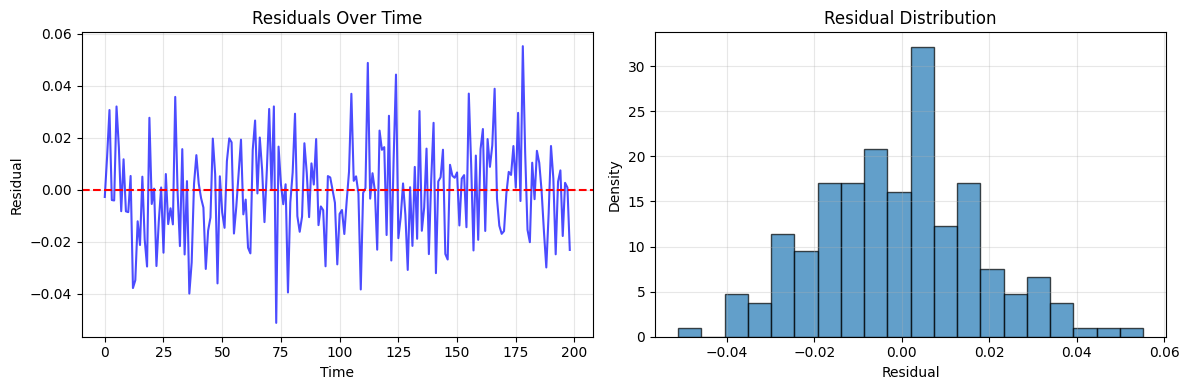

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# 1. SIMULATE DATA (In practice, you'd load real data)
# =============================================================================
np.random.seed(42)
T = 200
rho_true = 0.90
sigma_true = 0.02

# Generate AR(1) process
log_z = np.zeros(T)
epsilon = np.random.normal(0, sigma_true, T)
for t in range(1, T):
    log_z[t] = rho_true * log_z[t-1] + epsilon[t]

# =============================================================================
# 2. OLS ESTIMATION (No constant, as specified)
# =============================================================================
# Construct X (lagged) and y (current)
y = log_z[1:]       # z_t for t = 1, ..., T-1
X = log_z[:-1]      # z_{t-1} for t = 1, ..., T-1

# OLS formula (no constant): rho_hat = (X'X)^{-1} X'y
rho_hat = np.dot(X, y) / np.dot(X, X)

# Residuals
residuals = y - rho_hat * X

# Estimate sigma_epsilon
sigma_hat = np.std(residuals, ddof=1)  # ddof=1 for unbiased estimate

# =============================================================================
# 3. STANDARD ERROR FOR rho_hat
# =============================================================================
# Var(rho_hat) = sigma^2 / (X'X)
n = len(y)
s2 = np.sum(residuals**2) / (n - 1)  # Residual variance (1 parameter estimated)
se_rho = np.sqrt(s2 / np.dot(X, X))

# =============================================================================
# 4. DELIVERABLES
# =============================================================================
print("=" * 50)
print("AR(1) Estimation Results (OLS, No Constant)")
print("=" * 50)
print(f"Estimated rho:     {rho_hat:.4f}  (True: {rho_true})")
print(f"Estimation error:  {abs(rho_hat - rho_true):.4f}")
print(f"Standard error:    {se_rho:.4f}")
print(f"t-statistic:       {rho_hat / se_rho:.2f}")
print(f"")
print(f"Estimated sigma:   {sigma_hat:.4f}  (True: {sigma_true})")
print(f"Estimation error:  {abs(sigma_hat - sigma_true):.4f}")
print("=" * 50)

# Residual Diagnostics
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(residuals, 'b-', alpha=0.7)
axes[0].axhline(0, color='r', linestyle='--')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residual')
axes[0].set_title('Residuals Over Time')
axes[0].grid(True, alpha=0.3)

axes[1].hist(residuals, bins=20, density=True, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Density')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Critical Validation

**Checklist:**
1. ✅ **Parameter Recovery**: $\hat{\rho}$ and $\hat{\sigma}$ are close to true values.
2. ✅ **No Constant**: Matches RBC calibration convention.
3. ✅ **Residual Diagnostics**: No obvious autocorrelation pattern; approximately normal.
4. ✅ **Interpretable Output**: Clear reporting of estimates, errors, and standard errors.

**Economic Plausibility:**
- $\rho \approx 0.9$ implies highly persistent TFP shocks (realistic for quarterly data).
- $\sigma \approx 0.02$ implies 2% standard deviation of shocks (typical calibration).

# Part 3: Discussion

## When Does Prompt Precision Matter Most?

| Situation | Generic OK? | Specification Required? |
|-----------|-------------|------------------------|
| Learning syntax ("How do I write a for loop?") | ✅ | |
| Quick data exploration | ✅ | |
| Publishable research code | | ✅ |
| Models with known analytical solutions | | ✅ |
| Calibration/estimation for papers | | ✅ |
| Code that others will use | | ✅ |

## The Research Architect Checklist

Before prompting an AI for research code, ask yourself:

1. **Have I written down the math?** (Equations, constraints, objectives)
2. **Have I specified all parameters?** (Don't let AI choose $\beta = 0.99$ if you need $\beta = 0.96$)
3. **Have I defined the algorithm?** (VFI vs. PFI vs. projection)
4. **Have I stated convergence criteria?** (Tolerance, max iterations)
5. **Have I listed deliverables?** (Plots, tables, error metrics)
6. **Do I have a validation benchmark?** (Analytical solution, known result, unit test)

---

## Key Takeaways

1. **Generic prompts yield generic (often wrong) code.** AI makes assumptions that may not match your research needs.

2. **Specification-driven prompts yield verifiable code.** By choosing problems with closed-form solutions, you can validate numerical methods.

3. **The 5-step workflow forces clarity.** Writing math and pseudocode *before* coding prevents logic errors.

4. **Critical validation is non-negotiable.** Even "correct" code can be economically nonsensical.

---

## Next Steps

- **Lab 2**: We apply this workflow to computational basics—floating point errors, loops, and NumPy.
- **Exercise**: Take the optimal growth model and add stochastic TFP. Can you write a specification-driven prompt for it?

---
*Remember: You are the architect. The AI is a powerful but fallible assistant.*